In [81]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator
from ta.volatility import BollingerBands
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import datetime

In [82]:
# Project time frame
start_date = "2020-01-01"
end_date = "2025-05-01"

# Benchmark index
benchmark_symbol = "^GSPC"

# Top 10 symbols from each sector (replace with your actual tickers if needed)
sectors = {
    "Technology": ["AAPL", "MSFT", "NVDA", "AVGO", "ADBE", "CRM", "AMD", "CSCO", "INTC", "ORCL"],
    "Communication": ["GOOGL", "META", "NFLX", "TMUS", "DIS", "VZ", "T", "CHTR", "CMCSA", "WBD"],
    "Health": ["JNJ", "PFE", "ABBV", "LLY", "MRK", "TMO", "BMY", "UNH", "ABT", "CVS"],
    "Financials": ["JPM", "BAC", "WFC", "C", "GS", "MS", "AXP", "USB", "BK", "SCHW"],
    "Defensive": ["PG", "KO", "PEP", "WMT", "COST", "CL", "MO", "KMB", "MDLZ", "KR"],
    "Cyclical": ["AMZN", "HD", "LOW", "MCD", "NKE", "SBUX", "BKNG", "TGT", "EBAY", "GM"],
    "Property": ["PLD", "AMT", "CCI", "EQIX", "DLR", "SPG", "O", "PSA", "VTR", "EXR"]
}

# Flatten list of all tickers
all_symbols = [symbol for group in sectors.values() for symbol in group]

### Load from CSV

In [83]:
# Load dataset from CSV
import os

if os.path.exists("stock_sector_data.csv"):
    stock_df = pd.read_csv("stock_sector_data.csv", parse_dates=["Date"])
    print("Loaded dataset from CSV.")
else:
    print("CSV file not found. Please run the download step.")


Loaded dataset from CSV.


### Feature Engineering — Add Technical Indicators


In [84]:
def add_technical_indicators(df):
    result = []

    for symbol in df["Symbol"].unique():
        sub = df[df["Symbol"] == symbol].sort_values("Date").copy()

        # Momentum: past 1-week and 4-week returns
        sub["Return_1w"] = sub["Close"].pct_change(1)
        sub["Return_4w"] = sub["Close"].pct_change(4)

        # Volatility: Rolling std dev
        sub["Volatility_4w"] = sub["Close"].rolling(window=4).std()

        # RSI
        sub["RSI"] = RSIIndicator(close=sub["Close"], window=14).rsi()

        # SMA
        sub["SMA_10"] = SMAIndicator(close=sub["Close"], window=10).sma_indicator()

        # MACD
        macd = MACD(close=sub["Close"])
        sub["MACD"] = macd.macd_diff()

        # Bollinger Bands
        bb = BollingerBands(close=sub["Close"], window=20)
        sub["BB_Upper"] = bb.bollinger_hband()
        sub["BB_Lower"] = bb.bollinger_lband()

        result.append(sub)

    features_df = pd.concat(result).reset_index(drop=True)
    return features_df

features_df = add_technical_indicators(stock_df)
features_df = features_df.dropna()
features_df.head()


,Date,Open,High,Low,Close,Volume,Symbol,Sector,Return_1w,Return_4w,Volatility_4w,RSI,SMA_10,MACD,BB_Upper,BB_Lower
33,2020-08-19,113.094381,125.578087,112.731159,121.716690,1167933200,AAPL,Technology,0.080151,0.340983,7.145863,85.450113,99.590198,3.191935,117.631568,57.109403
34,2020-08-26,123.037991,131.443347,120.748943,130.838776,883855600,AAPL,Technology,0.074945,0.225751,10.646745,87.807067,103.755081,3.959343,124.976142,55.882607
35,2020-09-02,134.163836,134.544124,108.128702,110.010643,1021692400,AAPL,Technology,-0.159189,0.033357,9.453153,62.794676,105.879250,2.828669,126.169569,59.177466
36,2020-09-09,114.340082,117.499399,107.260862,112.662910,864867300,AAPL,Technology,0.024109,-0.000195,9.457901,64.193426,108.076653,2.059602,127.421279,62.431496
37,2020-09-16,112.360646,113.111469,100.532692,109.025803,998564100,AAPL,Technology,-0.032283,-0.104266,10.251878,60.816805,109.532201,1.151433,128.054979,65.479216


### Create Outperformance Label

In [85]:
def create_outperformance_labels(features_df, benchmark_df):
    # Calculate future return for S&P 500
    benchmark_df["Benchmark_Return_Next"] = benchmark_df["Close"].pct_change().shift(-1)

    # Ensure 'Date' columns are of the same type
    features_df["Date"] = pd.to_datetime(features_df["Date"])
    benchmark_df["Date"] = pd.to_datetime(benchmark_df["Date"])

    # Merge benchmark return into stock data
    df = features_df.merge(benchmark_df[["Date", "Benchmark_Return_Next"]], on="Date", how="left")

    # Calculate stock return next week
    price_col = "Adj Close" if "Adj Close" in df.columns else "Close"
    df["Stock_Return_Next"] = df.groupby("Symbol")[price_col].pct_change().shift(-1)

    # Label = 1 if stock outperforms benchmark, else 0
    df["Label"] = (df["Stock_Return_Next"] > df["Benchmark_Return_Next"]).astype(int)

    return df

# Load benchmark data from CSV
benchmark_df = pd.read_csv("stock_sector_data.csv", usecols=["Date", "Symbol", "Close"])
benchmark_df = benchmark_df[benchmark_df["Symbol"] == benchmark_symbol].reset_index(drop=True)

labeled_df = create_outperformance_labels(features_df, benchmark_df)
labeled_df[["Date", "Symbol", "Sector", "Stock_Return_Next", "Benchmark_Return_Next", "Label"]].tail()


,Date,Symbol,Sector,Stock_Return_Next,Benchmark_Return_Next,Label
17461,2025-04-02,^GSPC,Benchmark,0.083058,0.083058,0
17462,2025-04-09,^GSPC,Benchmark,-0.020174,-0.020174,0
17463,2025-04-16,^GSPC,Benchmark,0.051642,0.051642,0
17464,2025-04-23,^GSPC,Benchmark,0.001480,0.001480,0
17465,2025-04-30,^GSPC,Benchmark,NaN,NaN,0


### Train/Test Split & Preprocessing

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocess_data(df):
    # Drop rows where the label is missing (NaN due to shifting)
    df = df.dropna(subset=["Label"])
    
    # Fill remaining missing values with median (safe for numeric features)
    df = df.fillna(df.median(numeric_only=True))

    # Keep only numeric feature columns
    exclude_cols = ['Date', 'Symbol', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next']
    feature_columns = [col for col in df.columns if col not in exclude_cols and df[col].dtype != 'object']
    
    X = df[feature_columns]
    y = df["Label"].astype(int)  # Ensure label is int

    # Optional: Scaling (not strictly necessary for Random Forest)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y

# Split the data: train up to 2023, test after
train_data = labeled_df[labeled_df["Date"] < "2023-01-01"]
test_data = labeled_df[labeled_df["Date"] >= "2023-01-01"]

X_train, y_train = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)

### Train Random Forest Classifier

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluation: Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:")
print(roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))


Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.52      0.52      4540
           1       0.48      0.49      0.48      4122

    accuracy                           0.50      8662
   macro avg       0.50      0.50      0.50      8662
weighted avg       0.51      0.50      0.50      8662

ROC-AUC Score:
0.5058359356798269


### Feature Importance Plot

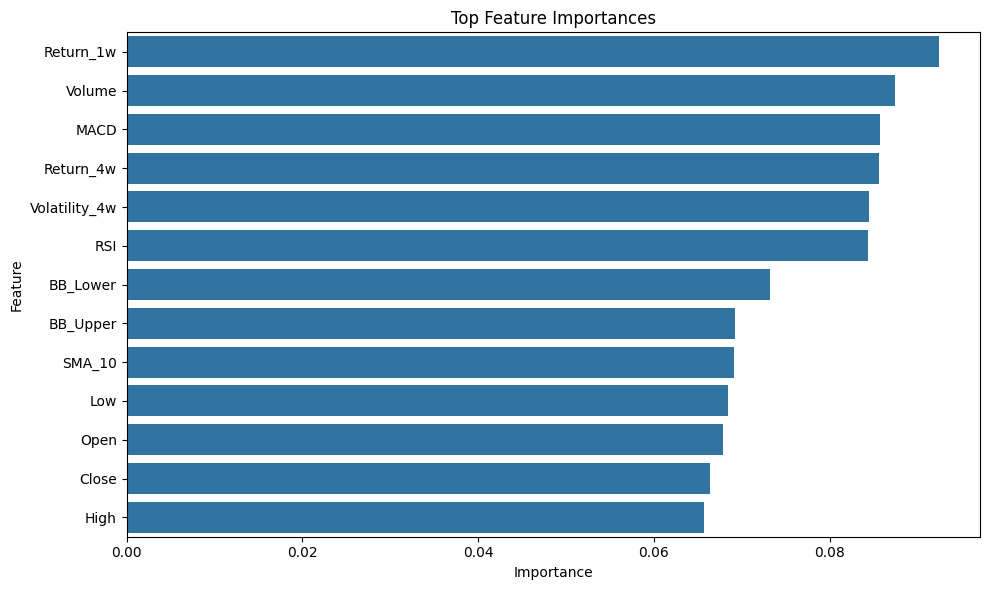

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

exclude_cols = ['Date', 'Symbol', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next']

# Get feature importances and names
feature_columns = [col for col in train_data.columns if col not in exclude_cols and train_data[col].dtype != 'object']
importances = rf_model.feature_importances_

# Create DataFrame for plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title('Top Feature Importances')
plt.tight_layout()
plt.show()

### Correlation Analysis

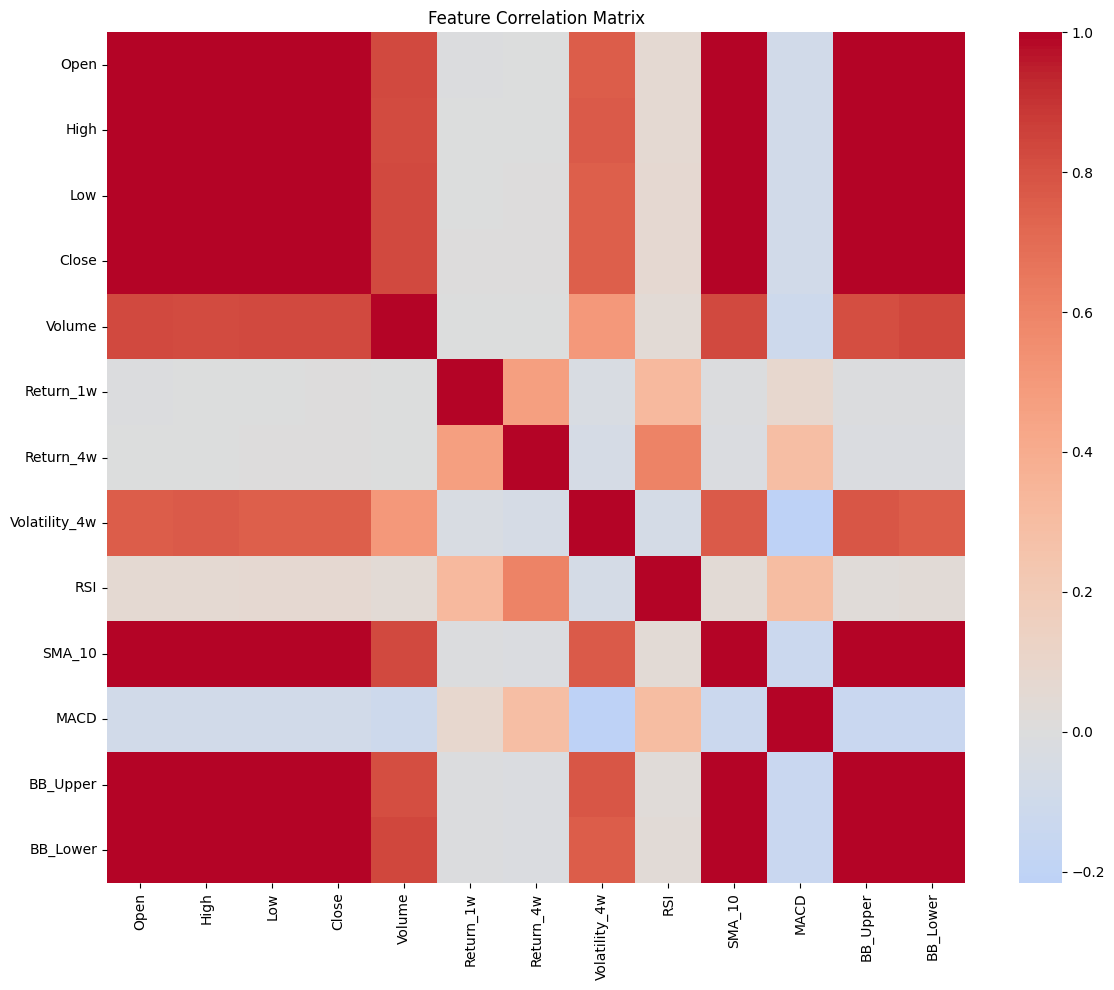

In [89]:
# Compute correlation matrix on the training features
exclude_cols = ['Date', 'Symbol', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next']

numeric_cols = [col for col in train_data.columns if col not in exclude_cols and train_data[col].dtype != 'object']
corr_matrix = train_data[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

### Reduce Multicollinearity

In [90]:
selected_features = [
    'Volume',
    'Return_1w',
    'Return_4w',
    'Volatility_4w',
    'RSI',
    'MACD'
    # Drop SMA_10, BB_Upper, BB_Lower, OHLCs
]

### Train/Test Split & Preprocessing after Reduce Multicollinearity

In [91]:
def preprocess_data(df):
    # Drop rows where the label is missing (NaN due to shifting)
    df = df.dropna(subset=["Label"])
    
    # Fill remaining missing values with median (safe for numeric features)
    df = df.fillna(df.median(numeric_only=True))

    # Use only selected features
    X = df[selected_features]
    y = df["Label"].astype(int)  # Ensure label is int

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y

# Split the data: train up to 2023, test after
X_train, y_train = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)


In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluation: Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:")
print(roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))


Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.53      0.52      4540
           1       0.47      0.46      0.46      4122

    accuracy                           0.49      8662
   macro avg       0.49      0.49      0.49      8662
weighted avg       0.49      0.49      0.49      8662

ROC-AUC Score:
0.5000858186543892


### Hyperparameter Tuning

In [93]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best parameters found: ", grid.best_params_)

Best parameters found:  {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [95]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None]
}

# Perform Randomized Search
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Output the best parameters
print("Best parameters found: ", random_search.best_params_)

Best parameters found:  {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 162}


In [94]:
# Apply the specified hyperparameters
rf_model = RandomForestClassifier(
    max_depth=10,
    max_features='log2',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=100,
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluation: Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:")
print(roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      4540
           1       0.47      0.49      0.48      4122

    accuracy                           0.50      8662
   macro avg       0.50      0.50      0.50      8662
weighted avg       0.50      0.50      0.50      8662

ROC-AUC Score:
0.500268624144218
